In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1234)
X, Y = make_moons(200, noise = 0.1)

# Split into test and training data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=73)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

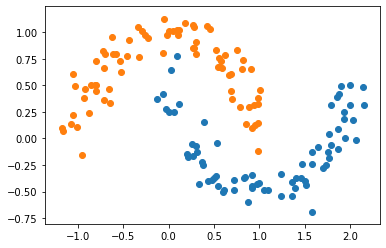

In [3]:
import matplotlib.pyplot as plt
plt.scatter(*x_train[y_train.flatten() == 1, :].T)
plt.scatter(*x_train[y_train.flatten() == 0, :].T)
plt.show()

In [4]:
type(x_train), np.shape(y_train)

(numpy.ndarray, (150, 1))

In [ ]:
# Standard BP
model_bp = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(100, activation = "sigmoid"),
        #layers.Dense(50, activation = "sigmoid"),
        layers.Dense(1, activation = "sigmoid")
    ]
)
model_bp.summary()
#model_bp.get_weights()

In [ ]:
import time
batch_size = 32
epochs = 1000
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

st = time.time()
model_bp.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model_bp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
print(time.time() - st)

In [5]:
def convert2_zero_one(x):
    
    t = [tm.sigmoid(i) for i in x]
    
    return t

In [6]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tm.greater(tm.abs(x), r), tf.float32)
    sign = tm.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [7]:
def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)


In [8]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=logits)
            
            ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels

In [9]:
model = StochasticMLP(hidden_layer_sizes = [100], n_outputs=1)

In [10]:
network = [model.call(x) for x, y in train_ds]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [11]:
kernels = [model.generate_hmc_kernel(x, y) for x, y in train_ds]

In [12]:
%%time

burnin = 500
for i in range(burnin):
    
    if(i % 100 == 0): print("Step %d" % i)
        
    network_new = []
    kernels_new = []
    
    res = [model.propose_new_state_hamiltonian(x, net, y, ker) 
               for (x, y), net, ker in zip(train_ds, network, kernels)]
    
    network_new, kernels_new = zip(*res)
         
    network = network_new
    kernels = kernels_new

Step 0
Step 100
Step 200
Step 300
Step 400
CPU times: user 1min 10s, sys: 859 ms, total: 1min 11s
Wall time: 1min 11s


In [13]:
print(network[0])

[<tf.Tensor: shape=(32, 100), dtype=float32, numpy=
array([[-353.09763 , -480.7659  , -248.21957 , ..., -227.4209  ,
         -20.72667 ,  278.59558 ],
       [ -25.334011,  423.945   , -214.96654 , ...,   78.27854 ,
        -239.08904 ,  365.50577 ],
       [-254.05093 ,   17.78176 , -736.2611  , ..., -195.07812 ,
        -201.33344 , -380.09515 ],
       ...,
       [ 399.5531  , -184.6452  , -145.47342 , ..., -368.80072 ,
          32.707024,   14.626984],
       [ 102.313354, -438.1059  ,  424.2397  , ..., -334.101   ,
        -295.98138 ,  -77.21953 ],
       [ 644.9836  ,  408.20123 ,  185.26974 , ...,  158.24371 ,
         163.33359 ,  727.41113 ]], dtype=float32)>]


In [14]:
epochs = 1000

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (x, y) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(x, network[bs], y, 0.1)
        res = [model.propose_new_state_hamiltonian(x, net, y, ker, is_update_kernel = False) \
                   for (x, y), net, ker in zip(train_ds, network, kernels)]
        network = res
        loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.concatenate(preds), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/1000: - 0.9430s/step - loss: 694.5419 - accuracy: 0.5133
Epoch 2/1000: - 0.8905s/step - loss: 693.9839 - accuracy: 0.5133
Epoch 3/1000: - 0.8632s/step - loss: 693.6526 - accuracy: 0.5133
Epoch 4/1000: - 0.8364s/step - loss: 693.4288 - accuracy: 0.6000
Epoch 5/1000: - 0.8209s/step - loss: 693.0852 - accuracy: 0.5133
Epoch 6/1000: - 0.8087s/step - loss: 692.9448 - accuracy: 0.5000
Epoch 7/1000: - 0.7995s/step - loss: 692.7964 - accuracy: 0.6000
Epoch 8/1000: - 0.8088s/step - loss: 692.6230 - accuracy: 0.5667
Epoch 9/1000: - 0.8036s/step - loss: 692.4446 - accuracy: 0.6400
Epoch 10/1000: - 0.7986s/step - loss: 692.2433 - accuracy: 0.7067
Epoch 11/1000: - 0.7934s/step - loss: 692.1597 - accuracy: 0.7733
Epoch 12/1000: - 0.7891s/step - loss: 692.0814 - accuracy: 0.8000
Epoch 13/1000: - 0.7927s/step - loss: 691.9809 - accuracy: 0.8000
Epoch 14/1000: - 0.7907s/step - loss: 691.9734 - accuracy: 0.8000
Epoch 15/1000: - 0.7906s/step - loss: 692.1539 - accuracy: 0.8000
Epoch 16/1000: - 0.

Epoch 125/1000: - 0.8050s/step - loss: 686.9438 - accuracy: 0.8667


KeyboardInterrupt: 